In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Tue Nov 25 11:41:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import random

# ============================================================
# 재현성을 위한 완벽한 시드 설정
# ============================================================
SEED = 42

random.seed(SEED)
import numpy as np
np.random.seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

try:
    tf.config.experimental.enable_op_determinism()
    tf.keras.utils.set_random_seed(SEED)
except:
    pass

print(f"🔒 All random seeds set to: {SEED}")
print(f"🔒 Deterministic operations: ENABLED\n")

# ============================================================


🔒 All random seeds set to: 42
🔒 Deterministic operations: ENABLED



In [4]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import backend as K

from keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Input
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score


In [5]:
# ============================================================
# FedProx 설정에 따른 하이퍼파라미터
# ============================================================
print("="*60)
print("FedProx Configuration - Federated Learning for RUL Prediction")
print("="*60)

# Dataset
CLIPPING_THRESHOLD = 125
PCA_COMPONENTS = 3
SEQUENCE_LENGTH = 30

# Model
LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 64
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.2

# Training - FedProx
NUM_CLIENTS = 3
GLOBAL_ROUNDS = 5
LOCAL_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.01

# FedProx 핵심 파라미터
MU = 0.01  # Proximal term coefficient (논문 권장: 0.001~0.1)

# Optimizer & Loss
OPTIMIZER = 'Adam'
LOSS_FUNCTION = 'mean_squared_error'

print(f"\n[Dataset Configuration]")
print(f"  RUL Clipping Threshold: {CLIPPING_THRESHOLD}")
print(f"  PCA Components: {PCA_COMPONENTS}")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")

print(f"\n[Model Architecture]")
print(f"  LSTM Layer 1: {LSTM_UNITS_1} units, Dropout: {DROPOUT_RATE_1}")
print(f"  LSTM Layer 2: {LSTM_UNITS_2} units, Dropout: {DROPOUT_RATE_2}")

print(f"\n[FedProx Configuration]")
print(f"  Algorithm: FedProx (with Proximal Term)")
print(f"  Proximal Coefficient (μ): {MU}")
print(f"  Number of Clients: {NUM_CLIENTS}")
print(f"  Global Rounds: {GLOBAL_ROUNDS}")
print(f"  Local Epochs: {LOCAL_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print("="*60 + "\n")


FedProx Configuration - Federated Learning for RUL Prediction

[Dataset Configuration]
  RUL Clipping Threshold: 125
  PCA Components: 3
  Sequence Length: 30

[Model Architecture]
  LSTM Layer 1: 128 units, Dropout: 0.3
  LSTM Layer 2: 64 units, Dropout: 0.2

[FedProx Configuration]
  Algorithm: FedProx (with Proximal Term)
  Proximal Coefficient (μ): 0.01
  Number of Clients: 3
  Global Rounds: 5
  Local Epochs: 30
  Batch Size: 32
  Learning Rate: 0.01



In [6]:
# ============================================================
# 데이터 로드
# ============================================================
df_train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/train_FD004.txt", sep=" ", header=None)
df_test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/test_FD004.txt", sep=" ", header=None)
df_RUL = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/RUL_FD004.txt", sep=" ", header=None)

# NaN columns 제거
df_train.drop(columns=[26,27], axis=1, inplace=True)
df_test.drop(columns=[26,27], axis=1, inplace=True)
df_RUL.drop(columns=[1], axis=1, inplace=True)

# columns 이름 설정
columns_train = ['unit_ID','time_in_cycles','setting_1', 'setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

df_train.columns = columns_train
df_test.columns = columns_train


In [7]:
# ============================================================
# TRAIN 데이터 전처리
# ============================================================
# RUL 생성
rul = pd.DataFrame(df_train.groupby('unit_ID')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_ID', 'max']
df_train = df_train.merge(rul, on=['unit_ID'], how='left')
df_train['RUL'] = df_train['max'] - df_train['time_in_cycles']
df_train.drop('max', axis=1, inplace=True)

# RUL Clipping
df_train['RUL'] = df_train['RUL'].clip(upper=CLIPPING_THRESHOLD)

# MinMax Normalization
df_train['cycle_norm'] = df_train['time_in_cycles']
cols_normalize = df_train.columns.difference(['unit_ID','time_in_cycles','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]),
                             columns=cols_normalize,
                             index=df_train.index)
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)

sensor_cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
               'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd',
               'PCNfR_dmd', 'W31', 'W32']

# PCA 적용
pca = PCA(n_components=PCA_COMPONENTS)
principal_components_train = pca.fit_transform(norm_train_df[sensor_cols])

pca_df_train = pd.DataFrame(data=principal_components_train,
                            columns=['PCA_1', 'PCA_2', 'PCA_3'],
                            index=norm_train_df.index)

norm_train_df = norm_train_df.drop(sensor_cols, axis=1)
norm_train_df = norm_train_df.join(pca_df_train)

join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df

In [8]:
# ============================================================
# TEST 데이터 전처리
# ============================================================
df_test['cycle_norm'] = df_test['time_in_cycles']
cols_normalize_2 = df_test.columns.difference(['unit_ID','time_in_cycles','RUL'])
norm_test_df = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize_2]),
                            columns=cols_normalize_2,
                            index=df_test.index)

principal_components_test = pca.transform(norm_test_df[sensor_cols])

pca_df_test = pd.DataFrame(data=principal_components_test,
                           columns=['PCA_1', 'PCA_2', 'PCA_3'],
                           index=norm_test_df.index)

norm_test_df = norm_test_df.drop(sensor_cols, axis=1)
norm_test_df = norm_test_df.join(pca_df_test)

test_join_df = df_test[df_test.columns.difference(cols_normalize_2)].join(norm_test_df)
df_test = test_join_df
df_test = df_test.reset_index(drop=True)


In [9]:
# ============================================================
# TEST 데이터 RUL 생성
# ============================================================
true_rul = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/RUL_FD004.txt", sep = '\\s+', header = None)

rul = pd.DataFrame(df_test.groupby('unit_ID')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_ID', 'max']
true_rul.columns = ['more']
true_rul['unit_ID'] = true_rul.index + 1
true_rul['max'] = rul['max'] + true_rul['more']
true_rul.drop('more', axis=1, inplace=True)

df_test = df_test.merge(true_rul, on=['unit_ID'], how='left')
df_test['RUL'] = df_test['max'] - df_test['time_in_cycles']
df_test.drop('max', axis=1, inplace=True)


In [10]:
# ============================================================
# 시퀀스 생성 함수
# ============================================================
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# Feature columns
sequence_cols = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 'PCA_1', 'PCA_2', 'PCA_3']

# 전체 시퀀스 생성
seq_gen = (list(gen_sequence(df_train[df_train['unit_ID']==id], SEQUENCE_LENGTH, sequence_cols))
           for id in df_train['unit_ID'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

label_gen = [gen_labels(df_train[df_train['unit_ID']==id], SEQUENCE_LENGTH, ['RUL'])
             for id in df_train['unit_ID'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

print(f"Total sequences: {seq_array.shape}")
print(f"Total labels: {label_array.shape}\n")


Total sequences: (53779, 30, 7)
Total labels: (53779, 1)



In [11]:
# ============================================================
# Custom Metrics
# ============================================================
def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse_keras(y_true, y_pred):
    """Root Mean Square Error (RMSE)"""
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


In [12]:
# ============================================================
# FedProx Custom Loss with Proximal Term
# ============================================================
class ProximalLoss:
    """
    FedProx의 핵심: 근위항(Proximal Term)을 포함한 손실 함수

    Loss = MSE(y_true, y_pred) + (μ/2) * ||w - w_global||²

    여기서 μ는 근위 계수, w는 로컬 가중치, w_global은 글로벌 가중치
    """
    def __init__(self, global_weights, mu=0.01):
        self.global_weights = global_weights
        self.mu = mu

    def __call__(self, model):
        """
        모델의 현재 가중치와 글로벌 가중치 간의 거리를 계산
        """
        def loss(y_true, y_pred):
            # 기본 MSE Loss
            mse_loss = K.mean(K.square(y_true - y_pred))

            # Proximal Term: (μ/2) * Σ||w_local - w_global||²
            proximal_term = 0.0
            local_weights = model.trainable_weights

            for w_local, w_global in zip(local_weights, self.global_weights):
                proximal_term += K.sum(K.square(w_local - w_global))

            proximal_term *= (self.mu / 2.0)

            # Total Loss
            total_loss = mse_loss + proximal_term

            return total_loss

        return loss


In [13]:
# ============================================================
# FedProx 클라이언트 업데이트 함수
# ============================================================
def client_update_fedprox(global_model, X_train, y_train, local_epochs,
                          batch_size, mu):
    """
    FedProx 클라이언트 로컬 업데이트

    핵심 차이점: 손실 함수에 근위항 추가
    min F_k(w) + (μ/2)||w - w^t||²
    """

    # 1. 로컬 모델 생성 및 글로벌 가중치 복사
    local_model = Sequential.from_config(global_model.get_config())
    local_model.set_weights(global_model.get_weights())

    # 2. 글로벌 가중치 저장 (Proximal term 계산용)
    global_weights = [tf.constant(w) for w in global_model.get_weights()]

    # 3. FedProx Loss (MSE + Proximal Term) 생성
    proximal_loss = ProximalLoss(global_weights, mu=mu)

    # 4. 로컬 모델 컴파일 (Custom Loss 사용)
    local_model.compile(
        loss=proximal_loss(local_model),
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['mae', r2_keras, rmse_keras]
    )

    # 5. 로컬 훈련
    initial_loss = local_model.evaluate(X_train, y_train, verbose=0)[0]

    history = local_model.fit(
        X_train, y_train,
        epochs=local_epochs,
        batch_size=batch_size,
        verbose=0
    )

    final_loss = history.history['loss'][-1]

    return (local_model.get_weights(), len(X_train),
            initial_loss, final_loss)


In [14]:
# ============================================================
# FedAvg 서버 집계 함수 (동일)
# ============================================================
def server_aggregate(global_model, client_weights_list, client_data_sizes):
    """서버 집계 (FedProx도 동일한 집계 방식 사용)"""

    total_data_size = sum(client_data_sizes)
    new_weights = [np.zeros_like(w) for w in global_model.get_weights()]

    for client_weights, data_size in zip(client_weights_list, client_data_sizes):
        weight_ratio = data_size / total_data_size

        for i in range(len(new_weights)):
            new_weights[i] += client_weights[i] * weight_ratio

    global_model.set_weights(new_weights)
    return global_model


In [15]:
# ============================================================
# 데이터 분할 (3 클라이언트)
# ============================================================
unique_ids = np.sort(df_train['unit_ID'].unique())
client_ids_groups = np.array_split(unique_ids, NUM_CLIENTS)

client_data = []
print(f"Data Partitioning into {NUM_CLIENTS} clients:\n")

start_idx = 0
for client_id, ids in enumerate(client_ids_groups):
    num_seqs = 0
    for uid in ids:
        unit_data = df_train[df_train['unit_ID']==uid]
        if len(unit_data) >= SEQUENCE_LENGTH:
            num_seqs += len(unit_data) - SEQUENCE_LENGTH

    X_c = seq_array[start_idx:start_idx+num_seqs]
    y_c = label_array[start_idx:start_idx+num_seqs]

    client_data.append((X_c, y_c))
    print(f"  Client {client_id+1}: {X_c.shape[0]:5d} sequences from {len(ids)} engines")
    start_idx += num_seqs

print()


Data Partitioning into 3 clients:

  Client 1: 17948 sequences from 83 engines
  Client 2: 18122 sequences from 83 engines
  Client 3: 17709 sequences from 83 engines



In [16]:
# ============================================================
# 모델 아키텍처
# ============================================================
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

# LSTM Layer 1: 128 units, Dropout 0.3
model.add(LSTM(
    units=LSTM_UNITS_1,
    return_sequences=True,
    input_shape=(SEQUENCE_LENGTH, nb_features)
))
model.add(Dropout(DROPOUT_RATE_1))

# LSTM Layer 2: 64 units, Dropout 0.2
model.add(LSTM(
    units=LSTM_UNITS_2,
    return_sequences=False
))
model.add(Dropout(DROPOUT_RATE_2))

# Output Layer
model.add(Dense(units=nb_out))
model.add(Activation("linear"))

# 초기 컴파일 (구조 확인용)
model.compile(
    loss=LOSS_FUNCTION,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['mae', r2_keras, rmse_keras]
)

print("="*60)
print("Model Architecture")
print("="*60)
print(model.summary())
print("="*60 + "\n")

# ============================================================
# FedProx 훈련
# ============================================================
print("="*60)
print("Starting FedProx Training")
print(f"Proximal Term Coefficient (μ): {MU}")
print("="*60)

global_model = model
training_history = {
    'round': [],
    'global_loss': [],
    'global_rmse': [],
    'global_r2': [],
    'avg_client_improvement': []
}

for round_num in range(GLOBAL_ROUNDS):
    print(f"\n{'='*60}")
    print(f"  Global Round {round_num + 1}/{GLOBAL_ROUNDS}")
    print(f"{'='*60}")

    client_weights_list = []
    client_data_sizes = []
    client_improvements = []

    # 클라이언트 로컬 훈련 (FedProx)
    for client_id in range(NUM_CLIENTS):
        X_c, y_c = client_data[client_id]

        weights, data_size, init_loss, final_loss = client_update_fedprox(
            global_model, X_c, y_c, LOCAL_EPOCHS, BATCH_SIZE, MU
        )

        client_weights_list.append(weights)
        client_data_sizes.append(data_size)
        improvement = init_loss - final_loss
        client_improvements.append(improvement)

        print(f"  Client {client_id+1}: Loss {init_loss:.2f} → {final_loss:.2f} "
              f"(Δ{improvement:+.2f})")

    # 서버 집계
    global_model = server_aggregate(global_model, client_weights_list, client_data_sizes)

    # 글로벌 모델 평가 (표준 MSE로 평가)
    global_model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['mae', r2_keras, rmse_keras]
    )

    loss, mae, r2, rmse = global_model.evaluate(seq_array, label_array, verbose=0)

    training_history['round'].append(round_num + 1)
    training_history['global_loss'].append(loss)
    training_history['global_rmse'].append(rmse)
    training_history['global_r2'].append(r2)
    training_history['avg_client_improvement'].append(np.mean(client_improvements))

    print(f"\n  Global Model Performance:")
    print(f"    Loss: {loss:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    print(f"    Avg Client Improvement: {np.mean(client_improvements):.2f}")

# 최종 모델 저장
model_path = 'fedprox_model.keras'
global_model.save(model_path)
print(f"\n{'='*60}")
print(f"FedProx Model saved to: {model_path}")
print(f"{'='*60}\n")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

None

Starting FedProx Training
Proximal Term Coefficient (μ): 0.01

  Global Round 1/5
  Client 1: Loss 9592.60 → 1012.47 (Δ+8580.14)
  Client 2: Loss 9655.30 → 1046.79 (Δ+8608.50)
  Client 3: Loss 9518.23 → 454.90 (Δ+9063.33)

  Global Model Performance:
    Loss: 2231.43 | RMSE: 43.71 | MAE: 42.90 | R²: -344757796864.0000
    Avg Client Improvement: 8750.66

  Global Round 2/5
  Client 1: Loss 2224.17 → 142.01 (Δ+2082.16)
  Client 2: Loss 2250.20 → 260.91 (Δ+1989.29)
  Client 3: Loss 2219.57 → 149.29 (Δ+2070.28)

  Global Model Performance:
    Loss: 1014.45 | RMSE: 28.40 | MAE: 27.06 | R²: -67479920640.0000
    Avg Client Improvement: 2047.24

  Global Round 3/5
  Client 1: Loss 976.65 → 134.40 (Δ+842.25)
  Client 2: Loss 1016.49 → 178.12 (Δ+838.37)
  Client 3: Loss 1050.67 → 93.53 (Δ+957.14)

  Global Model Performance:
    Loss: 706.33 | RMSE: 22.83 | MAE: 20.96 | R²: -85634334720.0000
    Avg Client Improvement: 879.25

  Global Round 4/5
  Client 1: Loss 704.14 → 108.38 (Δ+595.

In [17]:
# ============================================================
# 테스트 데이터 평가
# ============================================================
seq_array_test_last = [df_test[df_test['unit_ID']==id][sequence_cols].values[-SEQUENCE_LENGTH:]
                       for id in df_test['unit_ID'].unique()
                       if len(df_test[df_test['unit_ID']==id]) >= SEQUENCE_LENGTH]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(df_test[df_test['unit_ID']==id]) >= SEQUENCE_LENGTH
          for id in df_test['unit_ID'].unique()]

grouped_rul = df_test.groupby('unit_ID')['RUL'].nth(-1)
label_array_test_last = grouped_rul.iloc[y_mask].values
label_array_test_last = label_array_test_last.reshape(-1, 1).astype(np.float32)

print("="*60)
print("Final Test Evaluation (FedProx)")
print("="*60)

scores_test = global_model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)

print(f"\n{'='*60}")
print(f"FedProx Model Results:")
print(f"{'='*60}")
print(f"  Loss:  {scores_test[0]:.2f}")
print(f"  MAE:   {scores_test[1]:.2f}")
print(f"  R²:    {scores_test[2]:.4f}")
print(f"  RMSE:  {scores_test[3]:.2f}")
print(f"{'='*60}")

print(f"\n참고 - 논문 결과:")
print(f"  FedAvg  - Loss: 549.02, RMSE: 22.66")
print(f"  FedProx - (개선 기대)")
print(f"{'='*60}\n")


Final Test Evaluation (FedProx)
8/8 - 0s - 8ms/step - loss: 1844.6072 - mae: 33.9291 - r2_keras: 0.3493 - rmse_keras: 41.9189

FedProx Model Results:
  Loss:  1844.61
  MAE:   33.93
  R²:    0.3493
  RMSE:  41.92

참고 - 논문 결과:
  FedAvg  - Loss: 549.02, RMSE: 22.66
  FedProx - (개선 기대)



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


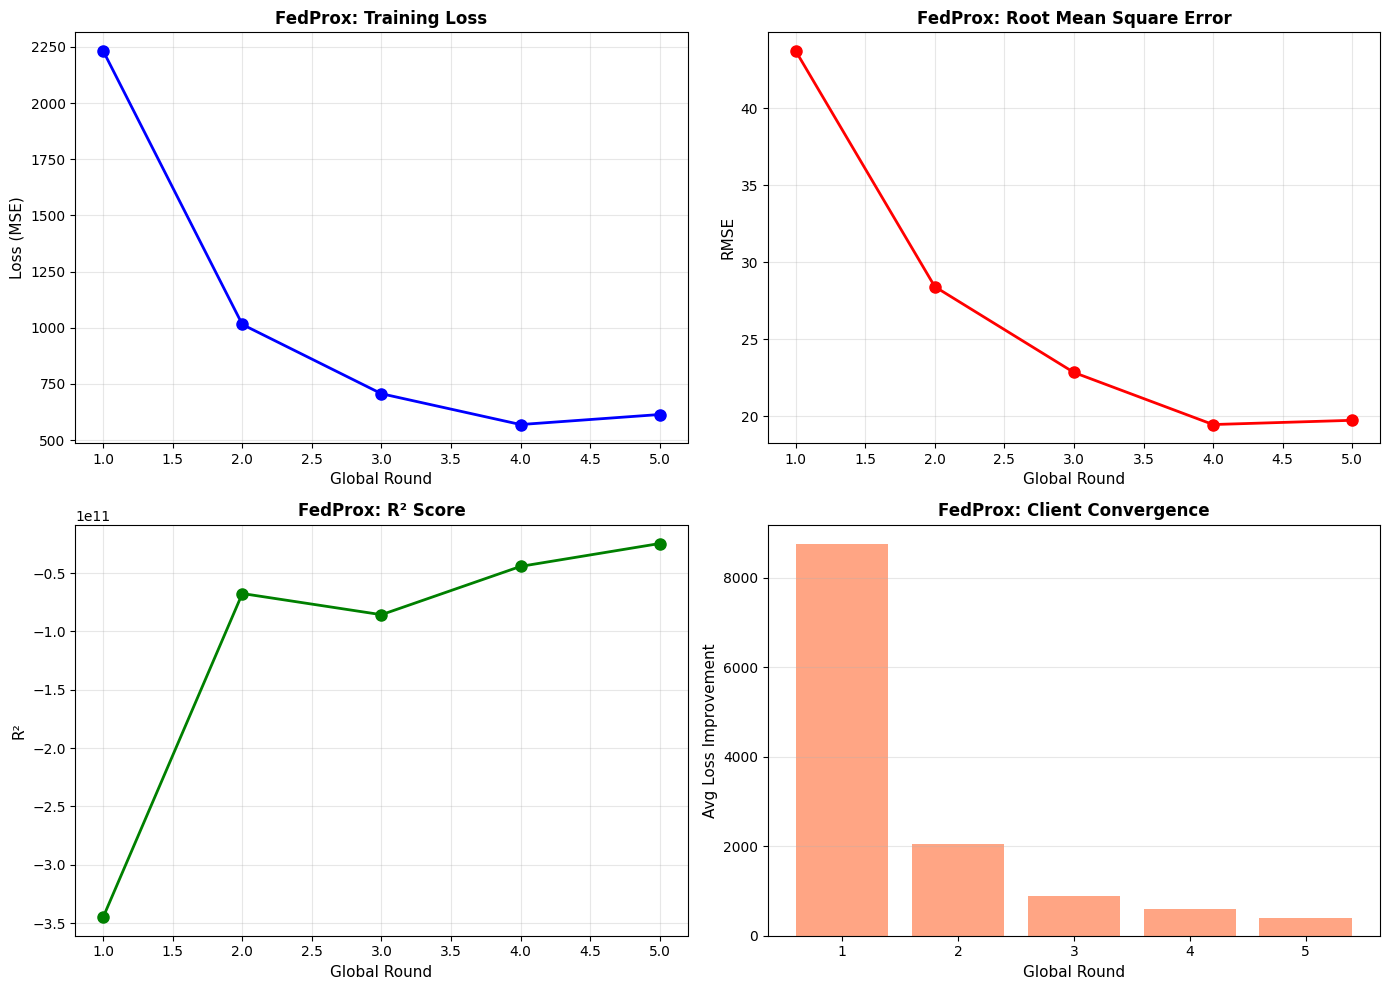

In [18]:
# ============================================================
# 시각화
# ============================================================
y_pred_test = global_model.predict(seq_array_test_last)
y_true_test = label_array_test_last

# 예측 결과 저장
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('fedprox_predictions.csv', index=None)

# 1. 훈련 과정 시각화
fig1, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(training_history['round'], training_history['global_loss'],
             'b-o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Global Round', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('FedProx: Training Loss', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].plot(training_history['round'], training_history['global_rmse'],
             'r-o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Global Round', fontsize=11)
axes[0, 1].set_ylabel('RMSE', fontsize=11)
axes[0, 1].set_title('FedProx: Root Mean Square Error', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# R²
axes[1, 0].plot(training_history['round'], training_history['global_r2'],
             'g-o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Global Round', fontsize=11)
axes[1, 0].set_ylabel('R²', fontsize=11)
axes[1, 0].set_title('FedProx: R² Score', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Client Improvement
axes[1, 1].bar(training_history['round'], training_history['avg_client_improvement'],
               color='coral', alpha=0.7)
axes[1, 1].set_xlabel('Global Round', fontsize=11)
axes[1, 1].set_ylabel('Avg Loss Improvement', fontsize=11)
axes[1, 1].set_title('FedProx: Client Convergence', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fedprox_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

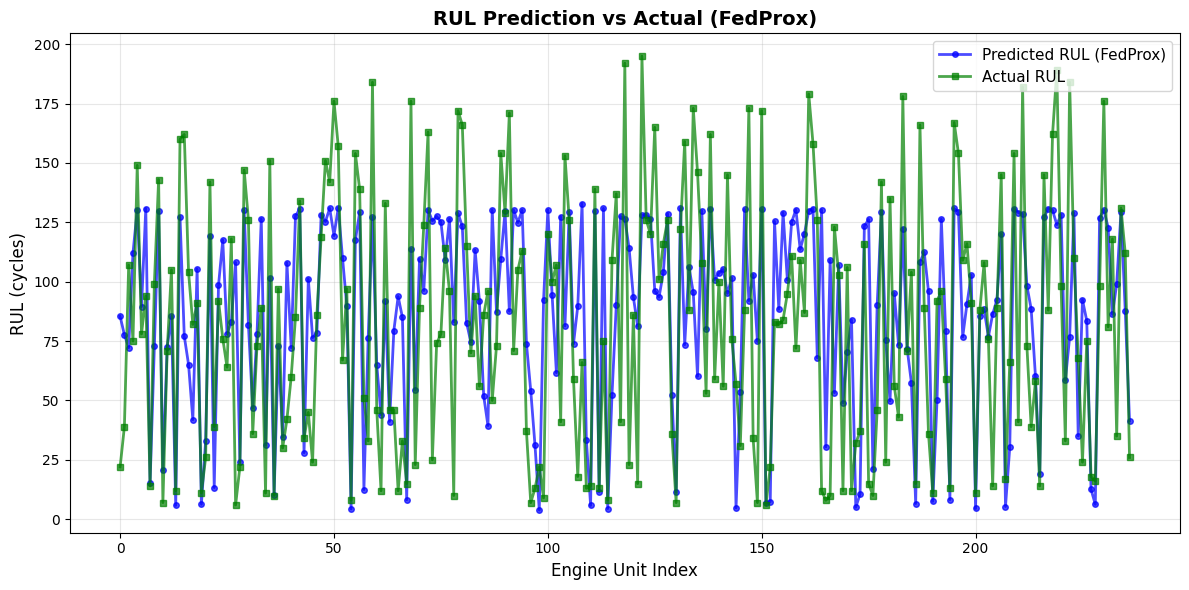

In [19]:
# 2. 예측 vs 실제
fig2 = plt.figure(figsize=(12, 6))

plt.plot(y_pred_test, color="blue", linewidth=2, marker='o', markersize=4,
         alpha=0.7, label='Predicted RUL (FedProx)')
plt.plot(y_true_test, color="green", linewidth=2, marker='s', markersize=4,
         alpha=0.7, label='Actual RUL')

plt.title('RUL Prediction vs Actual (FedProx)', fontsize=14, fontweight='bold')
plt.ylabel('RUL (cycles)', fontsize=12)
plt.xlabel('Engine Unit Index', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fedprox_prediction_results.png', dpi=150, bbox_inches='tight')
plt.show()

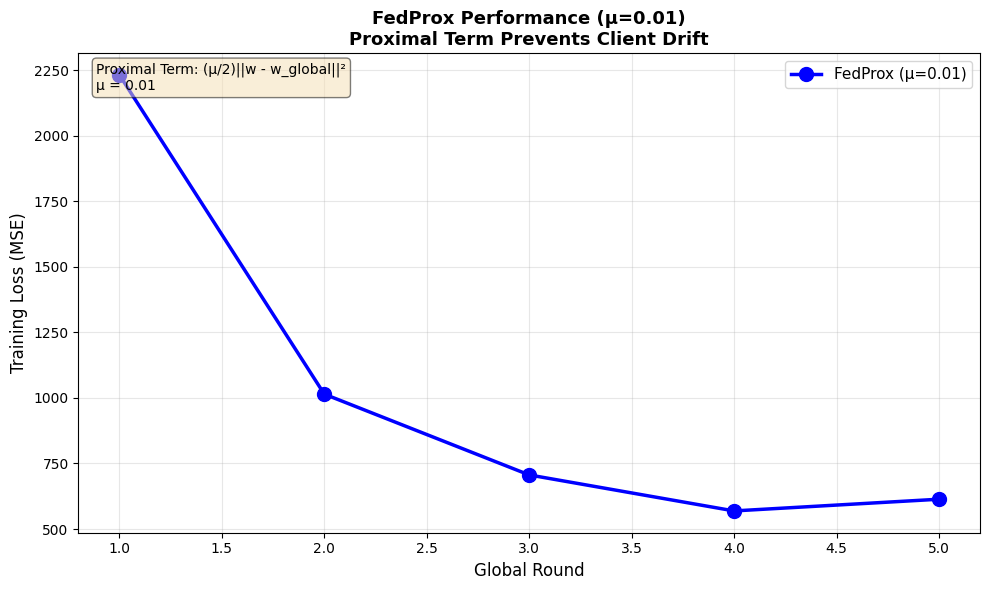

✓ All visualizations saved!
✓ FedProx training completed!

💡 FedProx Key Features:
   - Proximal term (μ=0.01) prevents client drift
   - Better convergence in Non-IID settings
   - More stable than FedAvg


In [20]:
# 3. FedProx 효과 시각화 (Proximal Term의 영향)
fig3 = plt.figure(figsize=(10, 6))

plt.plot(training_history['round'], training_history['global_loss'],
         'b-o', linewidth=2.5, markersize=10, label=f'FedProx (μ={MU})')

plt.xlabel('Global Round', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.title(f'FedProx Performance (μ={MU})\nProximal Term Prevents Client Drift',
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 설명 텍스트 추가
textstr = f'Proximal Term: (μ/2)||w - w_global||²\nμ = {MU}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('fedprox_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ All visualizations saved!")
print("✓ FedProx training completed!")
print(f"\n💡 FedProx Key Features:")
print(f"   - Proximal term (μ={MU}) prevents client drift")
print(f"   - Better convergence in Non-IID settings")
print(f"   - More stable than FedAvg")